In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
cache_dir = os.path.join('..', 'data')
train_data = pd.read_csv(os.path.join(cache_dir, 'train.csv'))
test_data = pd.read_csv(os.path.join(cache_dir, 'test.csv'))

In [3]:
train_data.head()

,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,...,"Garage, Garage - Attached, Covered",886486.0,12580.0,2019-10-24,4198000.0,NaN,NaN,Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,...,"Detached Carport, Garage",505000.0,6253.0,2019-10-16,525000.0,2019-08-30,328000.0,Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,...,NaN,49627.0,468.0,2019-08-25,180000.0,NaN,NaN,Strawberry,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947.0,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",NaN,...,"Detached Carport, Driveway, Garage - Two Door",1775000.0,20787.0,2019-10-24,1895000.0,2016-08-30,1500000.0,Culver City,90230,CA
4,4,7415 O Donovan Rd,1175000.0,Beautiful 200 acre ranch land with several pas...,VacantLand,NaN,NaN,NaN,0 spaces,NaN,...,NaN,NaN,NaN,2019-06-07,1595000.0,2016-06-27,900000.0,Creston,93432,CA


In [4]:
train_data['Sold Price'].fillna(train_data['Listed Price'], inplace=True)

In [5]:
all_features = pd.concat((train_data.iloc[:, train_data.columns != 'Sold Price'],
                         test_data))
all_features.drop('Id', 1, inplace=True)

/home/liwei/anaconda3/envs/yolo/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x-x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features = all_features[numeric_features]
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79065 entries, 0 to 31625
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year built                   79065 non-null  float64
 1   Lot                          79065 non-null  float64
 2   Bathrooms                    79065 non-null  float64
 3   Full bathrooms               79065 non-null  float64
 4   Total interior livable area  79065 non-null  float64
 5   Total spaces                 79065 non-null  float64
 6   Garage spaces                79065 non-null  float64
 7   Elementary School Score      79065 non-null  float64
 8   Elementary School Distance   79065 non-null  float64
 9   Middle School Score          79065 non-null  float64
 10  Middle School Distance       79065 non-null  float64
 11  High School Score            79065 non-null  float64
 12  High School Distance         79065 non-null  float64
 13  Tax assessed val

In [7]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, 
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, 
                             dtype=torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1, 1), 
                            dtype=torch.float32)

In [8]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

In [9]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 10), 
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(10, 6),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(6, 1))
    net.apply(init_weights)
    return net



def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
   

In [10]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [11]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, batch_size, weight_decay):
    train_ls, test_ls=[], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    updater = torch.optim.Adam(net.parameters(), 
                               lr = learning_rate, 
                               weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            updater.zero_grad()
            l = loss(net(X), y)
            l.backward()
            updater.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, train_features, train_labels))
    
    return train_ls, test_ls
        

In [12]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k 
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if i == j:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_part, y_part
            

In [13]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, test_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, test_ls = train(net, *data, num_epochs, learning_rate, batch_size, weight_decay)
        train_l_sum += train_ls[-1]
        test_l_sum += test_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, test_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'test'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(test_ls[-1]):f}')
        
        return train_l_sum / k , test_l_sum / k

fold 1, train log rmse 0.836662, valid log rmse 0.835264
5-折验证: 平均训练log rmse: 0.167332, 平均验证log rmse: 0.167053


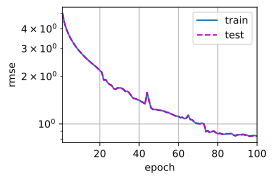

In [20]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 10, 2, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')


In [23]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)

In [24]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

KeyboardInterrupt: 